In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
print("training data shape:",training_data.data.shape)
print("training data[0] shape:",training_data.data[0].shape)
print("test data shape:",test_data.data.shape)
print("test data[0] shape:",test_data.data[0].shape)

print("---")
print(training_data.targets[0].item())

training data shape: torch.Size([60000, 28, 28])
training data[0] shape: torch.Size([28, 28])
test data shape: torch.Size([10000, 28, 28])
test data[0] shape: torch.Size([28, 28])
---
9


In [5]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X,y in test_dataloader:
    print(f"Shape of X [N,C,H,W]:{X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print("train_batch_num:",len(train_dataloader))
    print("test_batch_num:",len(test_dataloader))
    break

Shape of X [N,C,H,W]:torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
train_batch_num: 938
test_batch_num: 157


In [6]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
import os

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)     # 全连接层（如 nn.Linear）只能处理一维向量作为输入。
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
if os.path.exists("model.pth"):
    model.load_state_dict(torch.load("model.pth", weights_only=False))
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
import pandas as pd
train_loss = []

def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    model.train()
    loss = 0
    for batch,(X,y) in enumerate(dataloader):   # 循环每个batch=0.1.2.3...
        X,y = X.to(device),y.to(device)
        print(f"X shape: {X.shape} y shape: {y.shape}")
        print(y)
        pred = model(X)     # 预测
        loss = loss_fn(pred,y)  # 计算损失
        optimizer.zero_grad()   # 梯度清零
        loss.backward()         # 反向传播
        optimizer.step()        # 更新参数

        if batch % 100 == 0:
            print(f"loss: {loss.item():>7f}  [{batch * len(X):>5d}/{size:>5d}]")

    train_loss.append(loss.item())


In [10]:
test_loss = []
accuracy = []
def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)    
    num_batches = len(dataloader)
    model.eval()
    loss,correct = 0,0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            loss += loss_fn(pred,y).item() # 计算损失 将一个只包含单个元素的 PyTorch 张量（tensor）转换为对应的 Python 数值（如 float 或 int）。
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # 计算正确预测的数量 argmax(1) 沿着第1维（即每一行）找到最大值的索引，也就是模型预测的类别。
    loss /= num_batches
    correct /= size

    accuracy.append(correct)
    test_loss.append(loss)
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {loss:>8f} \n")


In [ ]:
epochs = 100

# 训练模型
for t in range(epochs):
    print(f"Epoch {t+1}\n------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    
    print("Saving loss")
    # 保存test_loss和train_loss到同一个csv文件
    pd.DataFrame({
        "train_loss": train_loss,
        "test_loss": test_loss,
        "accuracy": accuracy
    }).to_csv("loss_history.csv", index=False)

    print("Saving model...")
    torch.save(model.state_dict(), "model.pth")
    print("Saved PyTorch Model State to model.pth")
    print("Saving model done!")
print("Done!")

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
print(x,y)
print(x.shape,y.shape)
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

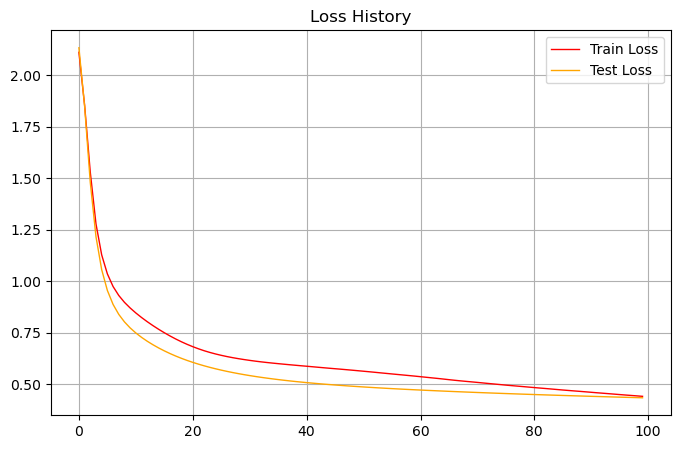

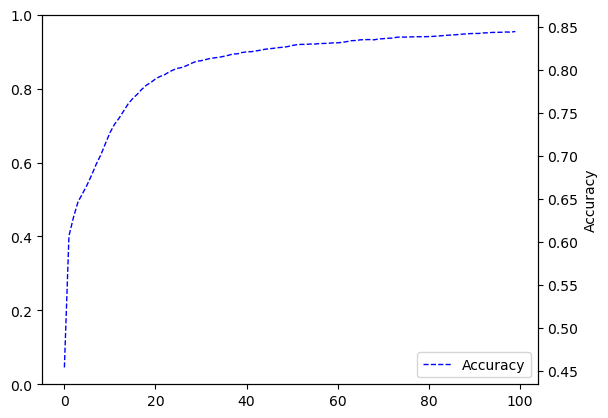

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设 loss_history 文件为 CSV 格式
# 如果是 txt 或其他格式，请根据实际情况调整
df = pd.read_csv('./loss_history_saved.csv')

# 假设有 'epoch' 和 'loss' 两列
plt.figure(figsize=(8, 5))
# plt.plot(df['epoch'], df['loss'], label='Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
plt.plot(np.arange(len(df['train_loss'])), df['train_loss'], label='Train Loss', color='red', linestyle='-', linewidth=1)
plt.plot(np.arange(len(df['test_loss'])), df['test_loss'], label='Test Loss', color='orange', linestyle='-', linewidth=1)


plt.title('Loss History')
plt.legend()
plt.grid(True)
plt.show()

plt.twinx()
plt.plot(np.arange(len(df['accuracy'])), df['accuracy'], label='Accuracy', color='blue', linestyle='--', linewidth=1)
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()